In [1]:
from src import *
import scipy.sparse.linalg as spsl
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Hamiltonian Parameters
num_qubits = 15
h_values = np.round(np.arange(.5,1.2,.05),2)
J = 1

# Algorithm Parameters
max_energy_level = 4
kd_ratio = 2.5
noise_threshold = 1e-2
epsilon = 1e-3
K = 500
delta_t_values = dict(zip(h_values,np.arange(.064,.104,.002)))
num_modmd_observables = 6
num_trials = 5

In [3]:
# Construct Hamiltonians, get true eigenergies
xx_strings = ['I' * i + 'ZZ' + 'I'* (num_qubits - i - 2) for i in range(num_qubits-1)]
z_strings = ['I' * i + 'X' + 'I'* (num_qubits - i - 1) for i in range(num_qubits)]

sparse_tfim_hamiltonians = {}
true_eigenenergies = {}

for h in h_values:
    sparse_tfim_hamiltonians[h] = SparsePauliOp.from_list([(s,-J) for s in xx_strings] + [(s,-h) for s in z_strings]).to_matrix(sparse=True)
    true_eigenenergies[h] = sorted(spsl.eigsh(sparse_tfim_hamiltonians[h],k=max_energy_level+1,which = 'SA')[0])

In [4]:
# Construct reference states
reference_states = {}
for h in h_values:
    indices = np.argsort(sparse_tfim_hamiltonians[h].diagonal())
    reference_states[h] = bitstring_superposition_state(num_qubits,[bin(indices[i])[2:] for i in range(6)])

# Get evolved reference states
d = int(K/kd_ratio)
evolved_reference_states = {}

for h in h_values:
    time_evolution_operator = -1j*sparse_tfim_hamiltonians[h]*delta_t_values[h]
    evolved_reference_states[h] = spsl.expm_multiply(time_evolution_operator,reference_states[h],start=0,stop=d+K+1,num = d+K+2)

In [5]:
# Load/generate observable set FIX THIS
try: 
    with open(f'Data/Observable Sets/one_local_paulis_{num_qubits}_qubits.pkl', 'rb') as f:
        modmd_observable_set = pickle.load(f)

except:
    modmd_observable_set = all_one_local_paulis(num_qubits)
    with open(f'Data/Observable Sets/one_local_paulis_{num_qubits}_qubits.pkl', 'wb') as f:
        pickle.dump(modmd_observable_set, f)

In [6]:
# ODMD Results
observables = [SparsePauliOp('I' * num_qubits).to_matrix(sparse=True)]
odmd_results = {h:[] for h in h_values}

for h in h_values:

    X_elements = generate_X_elements(observables,d,K,reference_states[h],evolved_reference_states[h])

    for trial in range(num_trials):

        gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
        noisy_X_elements = X_elements + gaussian_noise
        
        odmd_results[h].append(one_shot_modmd(len(observables),noise_threshold,X_elements,delta_t_values[h],K,kd_ratio,max_energy_level))

In [7]:
# MODMD Results
modmd_results = {h:[] for h in h_values}

for h in h_values:
    for trial in range(num_trials):
        print(f'H: {h}, Trial: {trial+1}')

        observables = np.random.choice(modmd_observable_set,num_modmd_observables,replace=False)
        X_elements = generate_X_elements(observables,d,K,reference_states[h],evolved_reference_states[h])
        
        gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
        noisy_X_elements = X_elements + gaussian_noise
        
        modmd_results[h].append(one_shot_modmd(len(observables),noise_threshold,X_elements,delta_t_values[h],K,kd_ratio,max_energy_level))

H: 0.5, Trial: 1
H: 0.5, Trial: 2
H: 0.5, Trial: 3
H: 0.5, Trial: 4
H: 0.5, Trial: 5
H: 0.55, Trial: 1
H: 0.55, Trial: 2
H: 0.55, Trial: 3
H: 0.55, Trial: 4
H: 0.55, Trial: 5
H: 0.6, Trial: 1
H: 0.6, Trial: 2
H: 0.6, Trial: 3
H: 0.6, Trial: 4
H: 0.6, Trial: 5
H: 0.65, Trial: 1
H: 0.65, Trial: 2
H: 0.65, Trial: 3
H: 0.65, Trial: 4
H: 0.65, Trial: 5
H: 0.7, Trial: 1
H: 0.7, Trial: 2
H: 0.7, Trial: 3
H: 0.7, Trial: 4
H: 0.7, Trial: 5
H: 0.75, Trial: 1
H: 0.75, Trial: 2
H: 0.75, Trial: 3
H: 0.75, Trial: 4
H: 0.75, Trial: 5
H: 0.8, Trial: 1
H: 0.8, Trial: 2
H: 0.8, Trial: 3
H: 0.8, Trial: 4
H: 0.8, Trial: 5
H: 0.85, Trial: 1
H: 0.85, Trial: 2
H: 0.85, Trial: 3
H: 0.85, Trial: 4
H: 0.85, Trial: 5
H: 0.9, Trial: 1
H: 0.9, Trial: 2
H: 0.9, Trial: 3
H: 0.9, Trial: 4
H: 0.9, Trial: 5
H: 0.95, Trial: 1
H: 0.95, Trial: 2
H: 0.95, Trial: 3
H: 0.95, Trial: 4
H: 0.95, Trial: 5
H: 1.0, Trial: 1
H: 1.0, Trial: 2
H: 1.0, Trial: 3
H: 1.0, Trial: 4
H: 1.0, Trial: 5
H: 1.05, Trial: 1
H: 1.05, Trial: 2
H: 1

In [8]:
# Compute errors
absolute_odmd_errors = {h: np.array([np.abs(odmd_results[h][i] - true_eigenenergies[h]) for i in range(num_trials)]) for h in h_values}
absolute_modmd_errors = {h: np.array([np.abs(modmd_results[h][i] - true_eigenenergies[h]) for i in range(num_trials)]) for h in h_values}

odmd_e1_errors_average = np.array([np.average(absolute_odmd_errors[h],0)[1] for h in h_values])
modmd_e1_errors_average = np.array([np.average(absolute_modmd_errors[h],0)[1] for h in h_values])

odmd_e1_errors_std = np.array([np.std(absolute_odmd_errors[h],0)[1] for h in h_values])
modmd_e1_errors_std = np.array([np.std(absolute_modmd_errors[h],0)[1] for h in h_values])

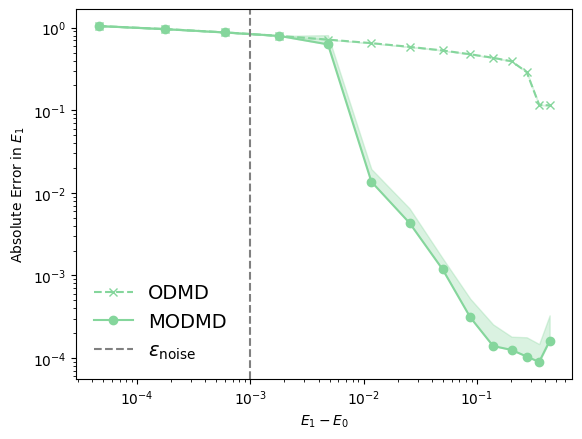

In [9]:
# Plotting
gaps = [true_eigenenergies[h][1] - true_eigenenergies[h][0] for h in h_values]

plt.loglog(gaps,odmd_e1_errors_average, '--x', label = 'ODMD', color = '#85d69c')
plt.loglog(gaps,modmd_e1_errors_average, '-o', label = 'MODMD', color = '#85d69c')

plt.fill_between(gaps,odmd_e1_errors_average,odmd_e1_errors_average + odmd_e1_errors_std,color = '#85d69c',alpha = .3)
plt.fill_between(gaps,modmd_e1_errors_average,modmd_e1_errors_average + modmd_e1_errors_std,color = '#85d69c',alpha = .3)

matplotlib.rcParams.update({'font.size': 14})
plt.axvline(epsilon, linestyle='--',color = 'grey', label = r'$\epsilon_\text{noise}$')
plt.xlabel('$E_1-E_0$')
plt.ylabel('Absolute Error in $E_1$')
plt.legend(framealpha=0,fontsize=14,loc='lower left')